## Overview
This notebook performs denoising on our BSDS300 images through non-learning methods. These methods include Bilateral Filtering, Non-Local Means, BM3D, and Anisotropic Diffusion.

User passes in either a Gaussian parameter, a Poisson parameter, or both. Result will show original clean image, noisy image, and results of the previously mentioned methods. Entire script is encapsulated in the denoise() function

In [20]:
import os
import logging
import warnings; warnings.filterwarnings("ignore");

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_nl_means, estimate_sigma
from torch.utils.data import DataLoader

from bm3d import bm3d_rgb
from experiment_funcs import get_experiment_noise
from BSDS300Dataset import BSDS300Dataset

In [2]:
# important image-related data
dynamicRange = [0.0, 1.0]

In [65]:
def applyGaussianNoise(img, sigma):
    noisyImg = img + np.random.normal(scale=sigma, size=img.shape).astype(img.dtype)
    noisyImgClipped = np.clip(noisyImg, dynamicRange[0], dynamicRange[1])
    return noisyImgClipped

def applyPoissonNoise(img, peak):
    noisyImg = (np.random.poisson(img * peak) / peak).astype(img.dtype)
    noisyImgClipped = np.clip(noisyImg, dynamicRange[0], dynamicRange[1])
    return noisyImgClipped
    
def bilateralFilter(src, noisyImg):
    """
    Denoises image using Bilateral Filtering
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    
    :return denoisedImg (np.ndarray): denoised image
    :return bilateralPsnr (float): PSNR between source and denoised image
    """
    
    denoisedImg = cv2.bilateralFilter(noisyImg,d=7,sigmaColor=75,sigmaSpace=75)
    bilateralPsnr = round(psnr(src, denoisedImg), 2)

    return denoisedImg, bilateralPsnr

def nlm(src, noisyImg):
    """
    Denoises image using Non-Local Means (NLM)
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    
    :return denoisedImg (np.ndarray): denoised image
    :return nlmPsnr (float): PSNR between source and denoised image
    """
    
    sigmaEstimated = np.mean(estimate_sigma(noisyImg))
    
    denoisedImg = denoise_nl_means(noisyImg, 
                                   h = sigmaEstimated, 
                                   fast_mode=True,
                                   patch_size=5,
                                   patch_distance=6,
                                   multichannel=True)
    
    nlmPsnr = round(psnr(src, denoisedImg), 2)
    return denoisedImg, nlmPsnr

def bm3d(src, noisyImg):
    """
    Denoises image using Block-Matching and 3-D Filtering (bm3d)
    
    :param src (np.ndarray): original image, no noise added
    :param noisyImg (np.ndarray): noisy image
    
    :return denoisedImg (np.ndarray): denoised image
    :return bm3dPsnr (float): PSNR between source and denoised image
    """
    
    noiseType = 'gw'    # white noise
    sigmaEstimated = np.mean(estimate_sigma(noisyImg))
    randomSeed = 0
    sz = noisyImg.shape
    noise, psd, kernel = get_experiment_noise(noise_type=noiseType,
                                              noise_var=sigmaEstimated,
                                              realization=randomSeed,
                                              sz=sz)
    denoisedImg = bm3d_rgb(noisyImg, psd)
    bm3dPsnr = round(psnr(src, denoisedImg), 2)
    return denoisedImg, bm3dPsnr

    

In [22]:
def denoiseWithAllMethods(path = None, img = None, sigma = None, peak = None):
    """
    Adds noise to source image, then denoises the result using a variety of 
    non-learning-based denoising methods.
    
    :param path (str): path to image (if not provided, function defaults to 'img' parameter)
    :param img (np.ndarray): image (if not provided, function defaults to 'path' parameter)
    :param sigma (float): variance of Gaussian noise
    :param peak (int): parameter used for applying Poisson noise
    
    :return gaussianImg (np.ndarray): source image perturbed with Gaussian noise
    :return gaussianDict (dict): maps to the results of each method (methods applied on Gaussian-perturbed images)
                                    along with the PSNR of those results
    :return poissonImg (np.ndarray): source image perturbed with Poisson noise
    :return poissonDict (dict): maps to the results of each method (methods applied on Poisson-perturbed images)
                                    along with the PSNR of those results
    """
    
    
    # Argument handling
    #--------------------------#
    if path is None and img is None:
        raise TypeError("Either image or image path must be provided.")
    
    if sigma is None and peak is None:
        raise TypeError("Received neither Gaussian parameter nor Poisson parameter.")
        
    if img is None:
        img = io.imread(path).astype(np.float32) / 255
        print(f"img dtype: {img.dtype}")
    #--------------------------#
    
    # Gaussian denoising
    #--------------------------#
    gaussianImg = applyGaussianNoise(img, sigma) if sigma != None else None
    gaussianDict = {}
    if sigma != None:
        bilateralResult, bilateralPsnr = bilateralFilter(img, gaussianImg)
        nlmResult, nlmPsnr = nlm(img, gaussianImg)
        bm3dResult, bm3dPsnr = bm3d(img, gaussianImg)
        gaussianDict["BF"] = (bilateralResult, bilateralPsnr)
        gaussianDict["NLM"] = (nlmResult, nlmPsnr)
        gaussianDict["BM3D"] = (bm3dResult, bm3dPsnr)

    #--------------------------#
    
    # Poisson denoising
    #--------------------------#
    poissonImg = applyPoissonNoise(img, peak) if peak != None else None
    poissonDict = {}
    if peak != None:
        bilateralResult, bilateralPsnr = bilateralFilter(img, poissonImg)
        nlmResult, nlmPsnr = nlm(img, poissonImg)
        bm3dResult, bm3dPsnr = bm3d(img, poissonImg)
        poissonDict["BF"] = (bilateralResult, bilateralPsnr)
        poissonDict["NLM"] = (nlmResult, nlmPsnr)
        poissonDict["BM3D"] = (bm3dResult, bm3dPsnr)
        
    #--------------------------#
    
    return gaussianImg, gaussianDict, poissonImg, poissonDict
    

In [23]:
def plotResults(img, gaussianImg, gaussianResults, poissonImg, poissonResults):
    """
    Plot the results of denoiseWithAllMethods.
    
    :param img (np.ndarray): Original image.
    :param gaussianImg (np.ndarray): Image perturbed by Gaussian noise
    :param gaussianResults (dict): maps to the results of each method (methods applied on Gaussian-perturbed images)
                                    along with the PSNR of those results
    :param poissonImg (np.ndarray): Image perturbed by Poisson Noise
    :param poissonResults (dict): maps to the results of each method (methods applied on Poisson-perturbed images)
                                    along with the PSNR of those results
    """
    
    fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(12,12))
    ax[0,0].imshow(img)
    ax[0,0].set_title("Original Image")

    ax[0,1].imshow(gaussianImg)
    ax[0,1].set_title("Image w/Gaussian Noise")

    ax[0,2].imshow(poissonImg)
    ax[0,2].set_title("Image w/Poisson Noise")

    result, psnr_ = gaussianResults["BF"]
    ax[1,0].imshow(result)
    ax[1,0].set_title(f"Bilateral Filter on Gaussian Noise ({psnr_})")

    result, psnr_ = gaussianResults["NLM"]
    ax[1,1].imshow(result)
    ax[1,1].set_title(f"NLM on Gaussian Noise ({psnr_})")

    result, psnr_ = gaussianResults["BM3D"]
    ax[1,2].imshow(result)
    ax[1,2].set_title(f"BM3D on Gaussian Noise ({psnr_})")

    result, psnr_ = poissonResults["BF"]
    ax[2,0].imshow(result)
    ax[2,0].set_title(f"Bilateral Filter on Poisson Noise ({psnr_})")

    result, psnr_ = poissonResults["NLM"]
    ax[2,1].imshow(result)
    ax[2,1].set_title(f"NLM on Poisson Noise ({psnr_})")

    result, psnr_ = poissonResults["BM3D"]
    ax[2,2].imshow(result)
    ax[2,2].set_title(f"BM3D on Poisson Noise ({psnr_})")

    plt.tight_layout()

img dtype: float32
img.dtype: float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


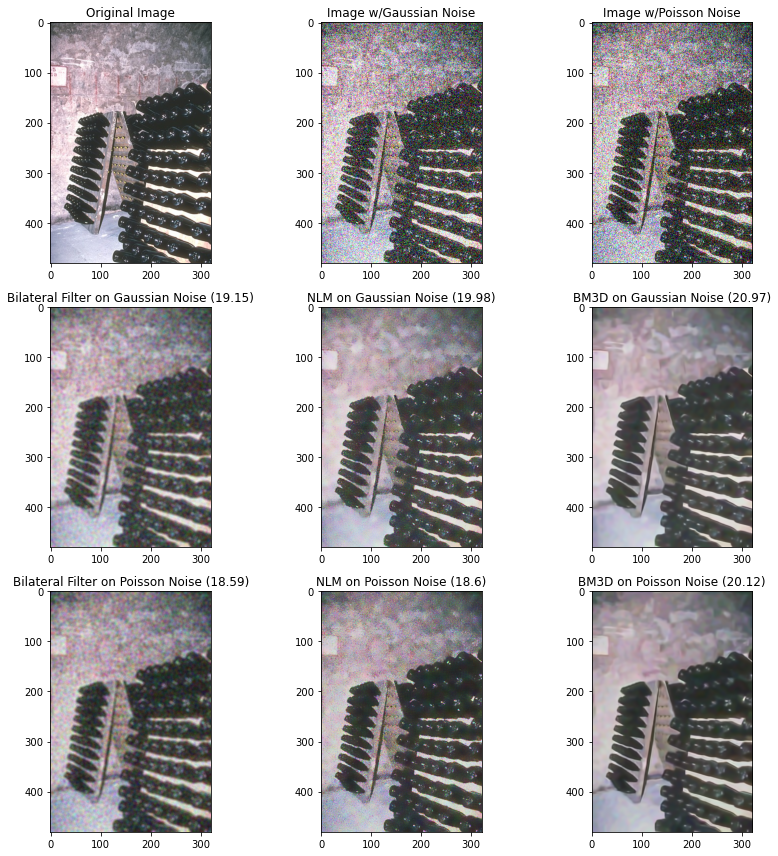

In [53]:
root = "BSDS300/images/"
dir = "train"    # can also be "test", refers one of the two directories in BSDS300/images/
img_fname = "157036.jpg"
img_path = os.path.join(root, dir, img_fname)
img = io.imread(img_path).astype(np.float32) / 255.0


gaussianImg, gaussianResults, poissonImg, poissonResults = denoiseWithAllMethods(path=img_path, 
                                                                                 sigma=0.3, 
                                                                                 peak=5)

plotResults(img, gaussianImg, gaussianResults, poissonImg, poissonResults)

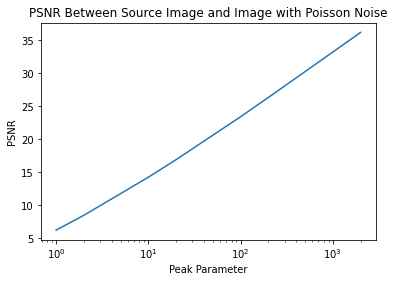

In [66]:
# Plot relationship between poisson "peak" parameter and psnr
fig = plt.figure()

peaks = [1, 2, 10, 20, 100, 200, 1000, 2000]
psnr_ = []

for peak in peaks:
    noisyImg = applyPoissonNoise(img, peak)
    psnr_.append(psnr(img,noisyImg))

ax = fig.add_subplot(1,1,1)
ax.plot(peaks, psnr_)
ax.set_xscale('log')
ax.set_xlabel("Peak Parameter")
ax.set_ylabel("PSNR")
ax.set_title("PSNR Between Source Image and Image with Poisson Noise")
plt.show()

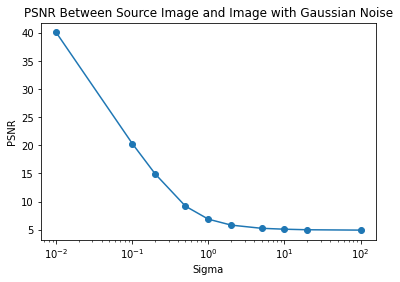

In [67]:
# Plot relationship between sigma and psnr
fig = plt.figure()

sigmas = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 100.0]
psnr_ = []

for sigma in sigmas:
    noisyImg = applyGaussianNoise(img, sigma)
    psnr_.append(psnr(img,noisyImg))

ax = fig.add_subplot(1,1,1)
ax.plot(sigmas, psnr_)
ax.scatter(sigmas, psnr_)
ax.set_xscale('log')
ax.set_xlabel("Sigma")
ax.set_ylabel("PSNR")
ax.set_title("PSNR Between Source Image and Image with Gaussian Noise")
plt.show()